# Hinglish Code-Mixing Analysis (en-IN Sarcasm)

This notebook implements an end-to-end analysis of Hinglish code-mixing for the English-India (en-IN) Reddit Sarcasm dataset from the BESSTIE repository.

**Scope:**
- Task: Sarcasm Detection
- Variety: en-IN (Reddit)
- Feature: Hinglish Code-Mixing (CMS)
- Method: FastText Language ID based detection

In [3]:
!unzip Archive.zip

Archive:  Archive.zip
replace Figures/bench.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [4]:
!pip -q install wordfreq
!pip -q install spacy
!python -m spacy download en_core_web_sm -q


Traceback (most recent call last):
  File "/usr/local/bin/pip3", line 4, in <module>
    from pip._internal.cli.main import main
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/main.py", line 11, in <module>
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/autocompletion.py", line 10, in <module>
    from pip._internal.cli.main_parser import create_main_parser
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/main_parser.py", line 10, in <module>
    from pip._internal.cli import cmdoptions
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/cmdoptions.py", line 24, in <module>
    from pip._internal.cli.parser import ConfigOptionParser
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/parser.py", line 11, in <module>
    from pip._internal.cli.status_codes import UNKNOWN_ERROR
  File "<frozen importlib._bootstrap>", line 1360, in _find_and_load
  File "<frozen importlib._bootstrap>", line 1331, in _find_a

## 1. Environment Setup

In [5]:
import os
import re
import glob
import urllib.request
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

# Check if running from repo root
cwd = os.getcwd()
print(f"Current Working Directory: {cwd}")

# Verify dataset paths
TRAIN_PATH = "Dataset/Splits/Sarcasm/en-IN/Reddit/train.csv"
VALID_PATH = "Dataset/Splits/Sarcasm/en-IN/Reddit/valid.csv"
TEST_PATH = "Dataset/Splits/Sarcasm/en-IN/Reddit/test.csv"


if not os.path.exists(TRAIN_PATH):
    raise FileNotFoundError(f"Train dataset not found at {TRAIN_PATH}")
if not os.path.exists(VALID_PATH):
    raise FileNotFoundError(f"Valid dataset not found at {VALID_PATH}")
print("Dataset paths verified.")

Current Working Directory: /content
Dataset paths verified.


In [6]:
# Install fasttext if not present
try:
    import fasttext
    print("fasttext already installed.")
except ImportError:
    print("fasttext not found. Installing...")
    !pip install fasttext
    import fasttext

# Download FastText Language ID model if missing
FT_MODEL_PATH = "lid.176.bin"
FT_MODEL_URL = "https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin"

if not os.path.exists(FT_MODEL_PATH):
    print(f"Downloading {FT_MODEL_PATH}...")
    urllib.request.urlretrieve(FT_MODEL_URL, FT_MODEL_PATH)
    print("Download complete.")
else:
    print(f"{FT_MODEL_PATH} already exists.")

# Load model
ft_model = fasttext.load_model(FT_MODEL_PATH)
print("FastText model loaded.")

fasttext already installed.
lid.176.bin already exists.
FastText model loaded.


## 2. Load Data

In [7]:
df_train = pd.read_csv(TRAIN_PATH)
df_valid = pd.read_csv(VALID_PATH)
df_test = pd.read_csv(TEST_PATH)


print(f"Train rows: {len(df_train)}")
print(f"Valid rows: {len(df_valid)}")
print(f"test rows: {len(df_test)}")

print("\nTrain Label Distribution:")
print(df_train['label'].value_counts())

print("\nSample Rows:")
display(df_train.head())

Train rows: 1686
Valid rows: 115
test rows: 115

Train Label Distribution:
label
0    1462
1     224
Name: count, dtype: int64

Sample Rows:


,id,text,label,is_cm
0,0,"Sigh, this is a typical ""uncle"" comment. I was...",0,False
1,1,Trailer toh accha hi dikh raha tha,0,True
2,2,Dude I knew people driving the small maruti in...,0,False
3,3,It also gets crowded in monsoon.\nEven though ...,0,True
4,4,Meanwhile T-Series Malkin...,1,False


## 3. Text Preprocessing + Tokenizer

In [8]:
def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', str(text))
    # Normalize whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def tokenize_and_filter(text):
    # Regex to capture words (with apostrophes/dashes) or emojis/symbols
    # We want to keep emojis but ignore pure punctuation for language ID check if strictly needed,
    # but for tokenizing we capture them.
    # Pattern matches words with optional internal apostrophes or dashes, OR non-whitespace chars (symbols)
    tokens = re.findall(r"[A-Za-z]+(?:[\'-][A-Za-z]+)*|[^\w\s]", text)
    return tokens

def is_eligible(token):
    # len >= 4 and contains at least one alphabetic char
    if len(token) < 3:
        return False
    if not re.search(r'[a-zA-Z]', token):
        return False
    return True

# Test tokenizer
sample_text = "Nahi bhai, this is time-pass only! 😂"
print(f"Original: {sample_text}")
tokens = tokenize_and_filter(clean_text(sample_text))
print(f"Tokens: {tokens}")
print(f"Eligible: {[t for t in tokens if is_eligible(t)]}")

Original: Nahi bhai, this is time-pass only! 😂
Tokens: ['Nahi', 'bhai', ',', 'this', 'is', 'time-pass', 'only', '!', '😂']
Eligible: ['Nahi', 'bhai', 'this', 'time-pass', 'only']


## 4. Hinglish Code-Mixing Detector (Core)

In [9]:
import re
from wordfreq import zipf_frequency

HINGLISH_SEEDS = {
    "bhai","bhaiya","yaar","paisa","sarkar","desh","dost","wala","wali","bakwas",
    "chutiya","gaali","kya","kyu","kyun","haan","han","nahi","nahin","matlab",
    "jaldi","abhi","arre","arey","mast","bindaas","jugaad","pyaar","pyar"
}

TOKEN_RE = re.compile(r"[A-Za-z]+(?:[\'-][A-Za-z]+)*")

def clean_text_minimal(text: str) -> str:
    text = re.sub(r'https?://\S+|www\.\S+', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def tokenize_words(text: str):
    return TOKEN_RE.findall(text)

def is_common_english(word: str, thr: float = 3.5) -> bool:
    # zipf_frequency: higher = more common
    return zipf_frequency(word, "en") >= thr

def looks_hinglish_romanized(word: str) -> bool:
    # very rough romanization cues
    markers = ("bh","kh","gh","ch","jh","sh","aa","ee","oo","ai","au","ya","ji")
    if any(m in word for m in markers):
        return True
    # endings often seen in romanized Hindi/Urdu
    if word.endswith(("wala","wali","ji","na","haan","nahin")):
        return True
    return False

def detect_hinglish_code_mixing(text: str):
    text = clean_text_minimal(str(text))
    tokens = [t.lower() for t in tokenize_words(text)]

    # eligible tokens, stricter to reduce noise
    eligible = [t for t in tokens if len(t) >= 4]

    if not eligible:
        return {
            "cm_hinglish_token_ratio": 0.0,
            "cm_switch_count": 0,
            "cm_score": 0.0,
            "is_cm": "False"
        }

    flags = []
    for t in eligible:
        if t in HINGLISH_SEEDS:
            flags.append(True)
            continue

        # only count as Hinglish if it looks romanized AND not common English
        if looks_hinglish_romanized(t) and (not is_common_english(t)):
            flags.append(True)
        else:
            flags.append(False)

    hinglish_count = sum(flags)
    cm_hinglish_token_ratio = hinglish_count / len(eligible)

    # switch count
    cm_switch_count = 0
    last = None
    for f in flags:
        cur = "HINGLISH" if f else "EN"
        if last is not None and cur != last:
            cm_switch_count += 1
        last = cur

    # score
    s1 = min(cm_hinglish_token_ratio / 0.30, 1.0)
    s2 = min(cm_switch_count / 5.0, 1.0)
    cm_score = 0.7 * s1 + 0.3 * s2


    if cm_score < 0.30:
        is_cm = "False"
    else:
        is_cm = "True"

    return {
        "cm_hinglish_token_ratio": float(cm_hinglish_token_ratio),
        "cm_switch_count": int(cm_switch_count),
        "cm_score": float(cm_score),
        "is_cm": is_cm
    }


## 5. Apply Detector to Datasets

In [10]:
from tqdm import tqdm
tqdm.pandas()

def apply_detector(df):
    results = df['text'].progress_apply(detect_hinglish_code_mixing)
    df_res = pd.DataFrame(results.tolist())
    return pd.concat([df, df_res], axis=1)

print("Processing Train Data...")
df_train_tagged = apply_detector(df_train)

print("Processing Valid Data...")
df_valid_tagged = apply_detector(df_valid)

print("Processing Valid Data...")
df_test_tagged = apply_detector(df_test)

# Save Tagged Outputs
train_out_path = "Dataset/Splits/Sarcasm/en-IN/Reddit/train_tagged_cm.csv"
valid_out_path = "Dataset/Splits/Sarcasm/en-IN/Reddit/valid_tagged_cm.csv"
test_out_path = "Dataset/Splits/Sarcasm/en-IN/Reddit/test_tagged_cm.csv"

df_train_tagged.to_csv(train_out_path, index=False)
df_valid_tagged.to_csv(valid_out_path, index=False)
df_test_tagged.to_csv(test_out_path, index=False)

print(f"Saved tagged datasets to:\n{train_out_path}\n{valid_out_path}")

Processing Train Data...


100%|██████████| 1686/1686 [00:00<00:00, 9073.91it/s]


Processing Valid Data...


100%|██████████| 115/115 [00:00<00:00, 11543.77it/s]


Processing Valid Data...


100%|██████████| 115/115 [00:00<00:00, 12312.89it/s]

Saved tagged datasets to:
Dataset/Splits/Sarcasm/en-IN/Reddit/train_tagged_cm.csv
Dataset/Splits/Sarcasm/en-IN/Reddit/valid_tagged_cm.csv


In [11]:
df_train_tagged

,id,text,label,is_cm,cm_hinglish_token_ratio,cm_switch_count,cm_score,is_cm
0,0,"Sigh, this is a typical ""uncle"" comment. I was...",0,False,0.033333,2,0.197778,False
1,1,Trailer toh accha hi dikh raha tha,0,True,0.500000,2,0.820000,True
2,2,Dude I knew people driving the small maruti in...,0,False,0.000000,0,0.000000,False
3,3,It also gets crowded in monsoon.\nEven though ...,0,True,0.125000,2,0.411667,True
4,4,Meanwhile T-Series Malkin...,1,False,0.000000,0,0.000000,False
...,...,...,...,...,...,...,...,...
1681,1681,Climate change is mostly caused by rich biatch...,1,False,0.034483,2,0.200460,False
1682,1682,Kuch bhi bakwas,0,True,1.000000,0,0.700000,True
1683,1683,Akshay Kumar and anyone less than 20 years you...,1,True,0.125000,1,0.351667,True
1684,1684,"CPI(M) called, they want you to be their brand...",1,False,0.000000,0,0.000000,False


In [13]:
# Sanity Check: Top 10 High cm_score examples from Train
print("Top 10 Code-Mixed Examples (Train):")
top_cm = df_train_tagged.sort_values(by='cm_score', ascending=False).head(10)
for idx, row in top_cm.iterrows():
    print(f"Score: {row['cm_score']:.2f} | Level: {row['is_cm']}")
    print(f"Text: {row['text']}")
    print("-"*50)

Top 10 Code-Mixed Examples (Train):
Score: 1.00 | Level: is_cm    True
is_cm    True
Name: 473, dtype: object
Text: Development ka naam sunke Dynasts aate honge gaali dene.
--------------------------------------------------
Score: 1.00 | Level: is_cm    True
is_cm    True
Name: 453, dtype: object
Text: Ubala hua anda maang rahi hai. Ek kaam karo isko ubla hua paani dedo, puche toh bolna anda andar pighal gaya.
--------------------------------------------------
Score: 1.00 | Level: is_cm    True
is_cm    True
Name: 531, dtype: object
Text: Acting in Heeramandi and putting up with Sharmin has made Aditi and Sonakshi friends for life. Same with Sanjeeda and Richa. Saw a sweet post by Sanjeeda about Ali and Richa gifting her daughter new clothes.
--------------------------------------------------
Score: 1.00 | Level: is_cm    True
is_cm    True
Name: 1585, dtype: object
Text: itne saste mae bik gaye , 3 lakh k chakkar me zindagi bhar ki beizzati 25-30 lakh hota toh kuch baat bhi hoti
-----

## 7. Visualization

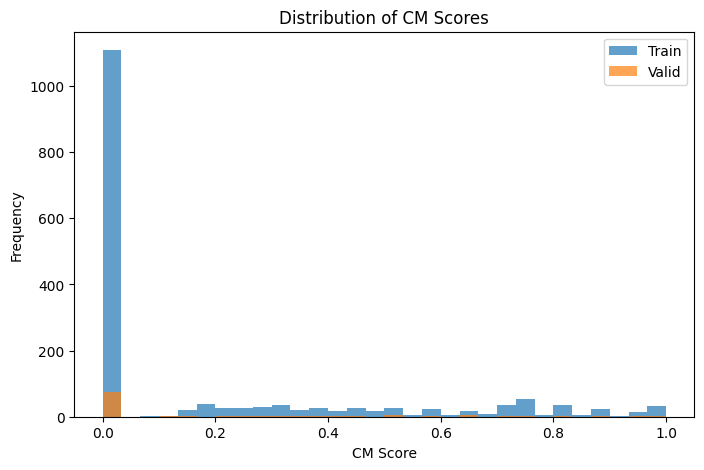

In [16]:
if 'df_res_table' in locals() and not df_res_table.empty:
    plt.figure(figsize=(8, 5))
    plot_data = df_res_table[df_res_table['is_cm'].isin(['False', 'True'])]




plt.figure(figsize=(8, 5))
plt.hist(df_train_tagged['cm_score'], bins=30, alpha=0.7, label='Train')
plt.hist(df_valid_tagged['cm_score'], bins=30, alpha=0.7, label='Valid')
plt.title('Distribution of CM Scores')
plt.xlabel('CM Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()